## Digital Twin Hotspot
#### The below script describes how we pull the data from the directory, arrange it, preprocess it and then feed it into a U-Net segmentation model for predicting the uplink and downlink throughput for each grid square in a given geographical region.

#### Input array contains 5 matrices  (256x256x5) 
m0 = No. of users per grid square

m1 = Whether there is a base station at this grid square or not

m2 = Height of the buildings at each grid square

m3 = lat co-ord of the grid

m4 = long co-ord of the grid


#### Output array contains 2 matrices (256x256x2)
m0 = uplink throughput

m1 = downlink throughput


In [1]:
import pandas as pd
import re
from copy import deepcopy
import glob
import numpy as np
from scipy.io import loadmat
from IPython.display import Image

### Data Generation Stage
Here in this stage, we pull all the data from our directory and sort them accordingly into two lists one for input and the other for the corresponding output value. 

In [2]:
# This function takes in the name of the folder that contains all the data as an input and returns two lists, 
# one for input and output 
def data_generate(name_of_directory):
    ls = glob.glob(name_of_directory+"/*.mat")
    input_data = []
    output_data = []
    for l in ls:
        if 'output' in l:
            output_data.append(l)
        else:
            input_data.append(l)  
    input_data.sort(key=natural_keys)
    output_data.sort(key=natural_keys) 
    return input_data, output_data

In [3]:
# An auxiliary function used during sorting of input and output matrices
def natural_keys(text):
    return int(re.split(r'(\d+)', text)[3])

### Data Preprocessing Stage
Here we define a function for processing the data, for both the input and the output, and store them by converting them from matlab format to numpy arrays

In [4]:
# A function which takes input (name of the matlab file, type) where type = input or output and converts it into
# a numpy array which can be fed into a model 
def data_process(matrix, label):
    mat = loadmat(matrix)
    if label == 'input':
        m0 = mat['mapData'][0][0][0]  # maximum number of users per qrid square
        m1 = mat['mapData'][0][0][1]  # Binary matrix so no need of standardization
        m2 = mat['mapData'][0][0][2]  # maximum height of a building 200
        return np.stack((m0, m1, m2), axis=-1).reshape((1, 256, 256, 3))
        
    elif label == 'output':
        m0 = mat['outputData'][0][0][0] 
        m1 = mat['outputData'][0][0][1] 
        return np.stack((m0, m1), axis=-1).reshape((1, 256, 256, 2))
        
    else:
        print("Pass correct data/label for input or output...")
        return None
    

### Data Aggregation Stage
In this stage we aggregate all the input and output arrays and dump them into a shape suitable to send into the model.

In [5]:
# A function to aggregate the input and output matrices into a suitable nd array
def data_aggregation(inp_mat, out_mat):
    inp_ls = []
    out_ls = []
    for inp, out in zip(inp_mat, out_mat):
        inp_ls.append(data_process(inp, 'input'))
        out_ls.append(data_process(out, 'output'))
    
    inp_ls = np.array(inp_ls).reshape((len(inp_ls), 256, 256, 3))
    out_ls = np.array(out_ls).reshape((len(out_ls), 256, 256, 2))
    
    inp_m_0 = deepcopy(np.mean(inp_ls[:,:,:,0]))
    inp_sd_0 = deepcopy(np.std(inp_ls[:,:,:,0]))
    
    inp_m_2 = deepcopy(np.mean(inp_ls[:,:,:,2]))
    inp_sd_2 = deepcopy(np.std(inp_ls[:,:,:,2]))
    
    x = (inp_ls[:,:,:,0]-inp_m_0)/inp_sd_0
    y = inp_ls[:,:,:,1]
    z = (inp_ls[:,:,:,2]-inp_m_2)/inp_sd_2

    
    inp_ls = np.stack((x, y, z), axis=-1).reshape((len(x), 256, 256, 3))

    out_0_min = np.min(out_ls[:,:,:,0])
    out_0_max = np.max(out_ls[:,:,:,0])
    out_1_min = np.min(out_ls[:,:,:,1])
    out_1_max = np.max(out_ls[:,:,:,1])
    
    p = (out_ls[:,:,:,0]-out_0_min)/(out_0_max - out_0_min)
    q = (out_ls[:,:,:,1]-out_1_min)/(out_1_max - out_1_min)

    out_ls = np.stack((p, q), axis=-1).reshape((len(p), 256, 256, 2))
    
    return inp_ls, out_ls, \
            inp_m_0, inp_sd_0, \
            inp_m_2, inp_sd_2, \
            out_0_min, out_0_max, \
            out_1_min, out_1_max 



### Build the segmentation model (U-Net Architecture)
Currently we are generating dummy input and output with shape (256x256x5) and (256x256x1) respectively to build the architecture of the model of U-Net (https://arxiv.org/pdf/1505.04597.pdf)

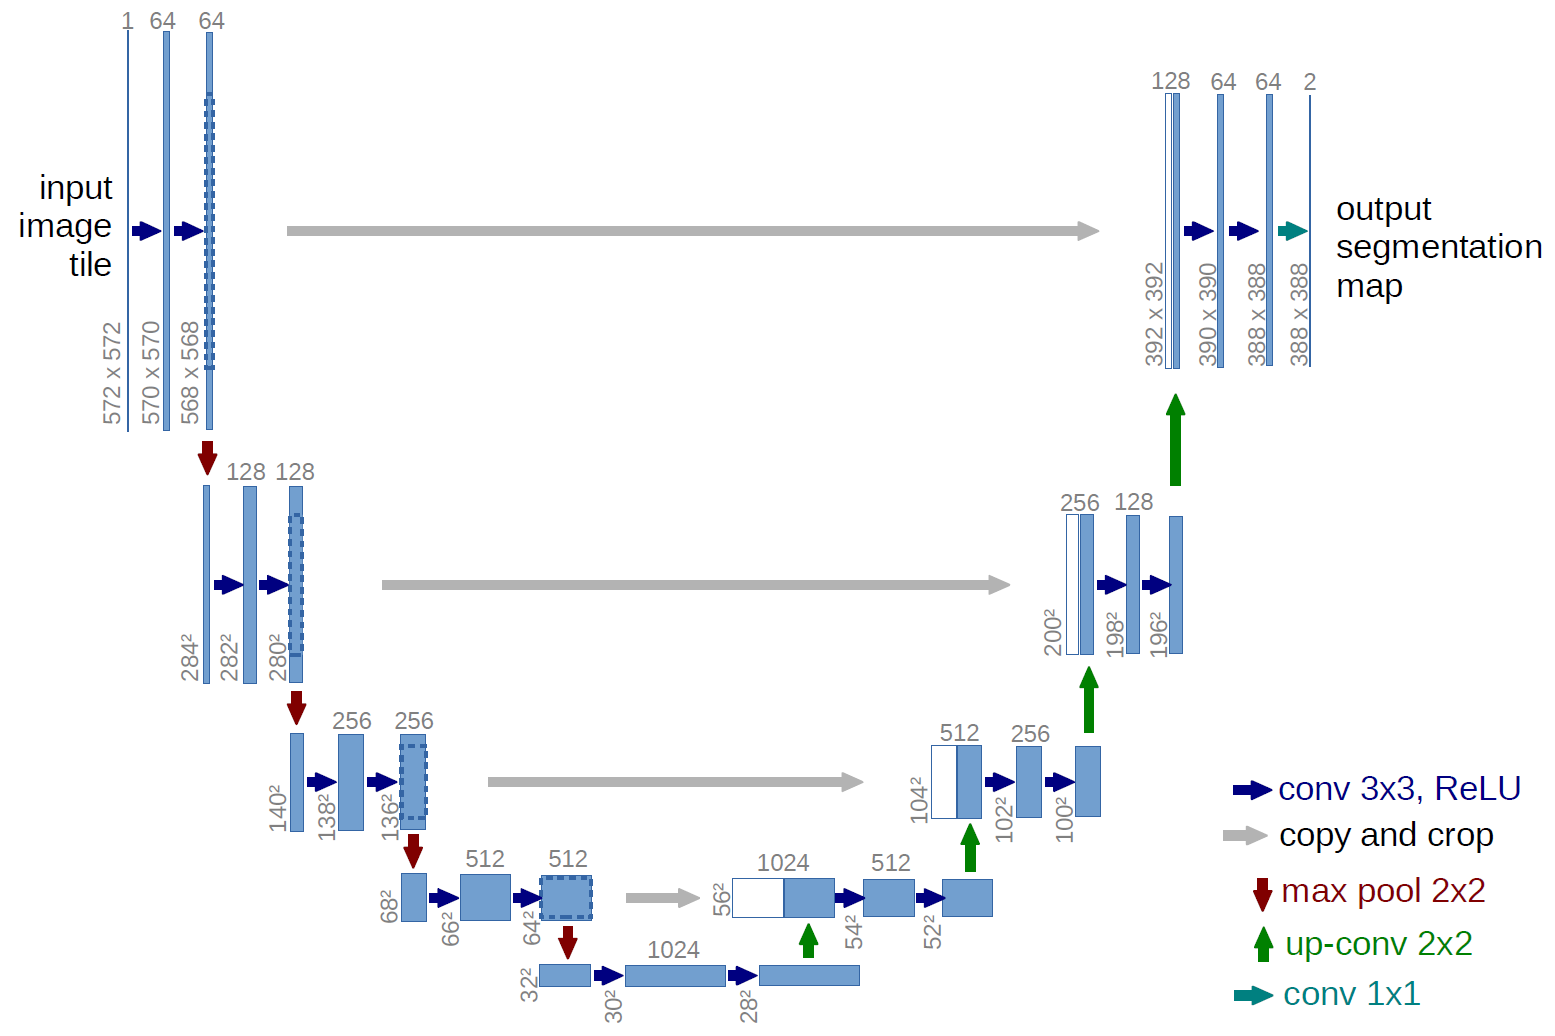

In [6]:
Image(filename="model.png", width=800, height=200)

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras import regularizers
from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#### Use all the above defined auxiliary functions to import training data and pre-process it


In [9]:
# Preprocessing the data to make it ready for training

# Step 1: Pull the data from the directory
input_matrices, output_matrices = data_generate("model_data")
# Step 2: Aggregate the data by preprocessing them and rearranging them into desired numpy arrays 
input_matrices, output_matrices, inp_m_0, inp_s_0, inp_m_2, inp_s_2, out_0_min, out_0_max, out_1_min, out_1_max = data_aggregation(input_matrices, output_matrices)
# # Step 3: Perform the train-test split 80%-20%
X_train, X_test, y_train, y_test = train_test_split(input_matrices, output_matrices, test_size=0.2, random_state=42)
# # # State the dimensions required to build the segmentation model 
MAT_HEIGHT, MAT_WIDTH, MAT_DEPTH = input_matrices.shape[1], input_matrices.shape[2], input_matrices.shape[3]

In [10]:
# Check the shapes of all the training and testing data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((259, 256, 256, 3), (65, 256, 256, 3), (259, 256, 256, 2), (65, 256, 256, 2))

#### Defining custom loss functions for the regression task in Keras

In [11]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

#### Define the architecture of the model 

In [12]:
# def a modified version of conv layer
def conv2d_block(input_tensor, n_filters, drop, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', 
               kernel_regularizer= regularizers.l1(0.01))(input_tensor)
    # Apply batchnorm 
    if batchnorm:
        x = BatchNormalization()(x)
    # activation layer
    x = Activation('relu')(x)
    # dropout layer
    x = Dropout(drop)(x)
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), 
               kernel_initializer = 'he_normal', padding = 'same', 
               kernel_regularizer= regularizers.l1(0.01))(input_tensor)
    # Apply batchnorm 
    if batchnorm:
        x = BatchNormalization()(x)
    # activation layer
    x = Activation('relu')(x)
    
    return x


# Define the architecture of the model
def U_Net(MAT_HEIGHT, MAT_WIDTH, MAT_DEPTH):
    inputs = Input((MAT_HEIGHT, MAT_WIDTH, MAT_DEPTH))
      
    conv1 = conv2d_block(inputs, 16, 0.1, batchnorm=True)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = conv2d_block(pool1, 32, 0.1, batchnorm=True)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = conv2d_block(pool2, 64, 0.2, batchnorm=True)
    pool3 = MaxPooling2D((2,2))(conv3)

    conv4 = conv2d_block(pool3, 128, 0.2, batchnorm=True)
    pool4 = MaxPooling2D((2,2))(conv4)

    conv5 = conv2d_block(pool4, 256, 0.3, batchnorm=True)
    
    convT1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
    convT1 = concatenate([convT1, conv4])
    conv6 = conv2d_block(convT1, 128, 0.2, batchnorm=True)
    
    convT2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)
    convT2 = concatenate([convT2, conv3])
    conv7 = conv2d_block(convT2, 64,  0.2, batchnorm=True)
    
    convT3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)
    convT3 = concatenate([convT3, conv2])
    conv8 = conv2d_block(convT3, 32, 0.1, batchnorm=True)

    convT4 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)
    convT4 = concatenate([convT4, conv1])
    conv9 = conv2d_block(convT4, 16, 0.1, batchnorm=True)
    
    outputs = Conv2D(2, (1,1), activation='relu', kernel_regularizer= regularizers.l1(0.01))(conv9)
    nadam = optimizers.Nadam(lr=0.0001)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=nadam, loss='mean_absolute_error',
                  metrics=['mean_absolute_error', 'mean_squared_error', rmse, r_square])
    
    return model
    
    

In [14]:
model = U_Net(MAT_HEIGHT, MAT_WIDTH, MAT_DEPTH)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 256, 16) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

#### Start the training process

In [15]:
# Fit the model
earlystopper = EarlyStopping(monitor="mean_absolute_error", patience=5, verbose=1)
checkpointer = ModelCheckpoint('digital_twin_mod.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=16, epochs=250, callbacks=[earlystopper, checkpointer], 
                   validation_data=(X_test, y_test))

Train on 259 samples, validate on 65 samples
Epoch 1/250
259/259 [==============================] - 43s 165ms/step - loss: 258.4353 - mean_absolute_error: 0.5453 - mean_squared_error: 0.7510 - rmse: 0.6630 - r_square: -55.5582 - val_loss: 251.8740 - val_mean_absolute_error: 0.5206 - val_mean_squared_error: 0.6914 - val_rmse: 0.6341 - val_r_square: -51.0888

Epoch 00001: val_loss improved from inf to 251.87398, saving model to digital_twin_mod.h5
Epoch 2/250
259/259 [==============================] - 42s 161ms/step - loss: 246.2958 - mean_absolute_error: 0.5202 - mean_squared_error: 0.6908 - rmse: 0.6330 - r_square: -51.0235 - val_loss: 239.3329 - val_mean_absolute_error: 0.4872 - val_mean_squared_error: 0.6140 - val_rmse: 0.5945 - val_r_square: -45.2625

Epoch 00002: val_loss improved from 251.87398 to 239.33295, saving model to digital_twin_mod.h5
Epoch 3/250
259/259 [==============================] - 42s 162ms/step - loss: 233.7993 - mean_absolute_error: 0.4950 - mean_squared_error: 

Epoch 21/250
259/259 [==============================] - 74s 287ms/step - loss: 78.3763 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0323 - rmse: 0.1106 - r_square: -1.4354 - val_loss: 75.4557 - val_mean_absolute_error: 0.0917 - val_mean_squared_error: 0.0340 - val_rmse: 0.1157 - val_r_square: -1.5635

Epoch 00021: val_loss improved from 80.80106 to 75.45566, saving model to digital_twin_mod.h5
Epoch 22/250
259/259 [==============================] - 73s 282ms/step - loss: 73.1678 - mean_absolute_error: 0.0809 - mean_squared_error: 0.0288 - rmse: 0.1021 - r_square: -1.1680 - val_loss: 70.4090 - val_mean_absolute_error: 0.0836 - val_mean_squared_error: 0.0294 - val_rmse: 0.1053 - val_r_square: -1.2169

Epoch 00022: val_loss improved from 75.45566 to 70.40903, saving model to digital_twin_mod.h5
Epoch 23/250
259/259 [==============================] - 74s 286ms/step - loss: 68.2517 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0262 - rmse: 0.0951 - r_square: -0.9695 - val_l

259/259 [==============================] - 126s 488ms/step - loss: 18.1695 - mean_absolute_error: 0.0447 - mean_squared_error: 0.0158 - rmse: 0.0548 - r_square: -0.1869 - val_loss: 17.4583 - val_mean_absolute_error: 0.0383 - val_mean_squared_error: 0.0135 - val_rmse: 0.0462 - val_r_square: -0.0155

Epoch 00041: val_loss improved from 18.74953 to 17.45832, saving model to digital_twin_mod.h5
Epoch 42/250
259/259 [==============================] - 108s 419ms/step - loss: 16.8830 - mean_absolute_error: 0.0434 - mean_squared_error: 0.0154 - rmse: 0.0530 - r_square: -0.1576 - val_loss: 16.1963 - val_mean_absolute_error: 0.0377 - val_mean_squared_error: 0.0134 - val_rmse: 0.0453 - val_r_square: -0.0080

Epoch 00042: val_loss improved from 17.45832 to 16.19626, saving model to digital_twin_mod.h5
Epoch 43/250
259/259 [==============================] - 133s 515ms/step - loss: 15.6934 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0152 - rmse: 0.0520 - r_square: -0.1451 - val_loss: 15.05

259/259 [==============================] - 75s 288ms/step - loss: 5.0120 - mean_absolute_error: 0.0310 - mean_squared_error: 0.0098 - rmse: 0.0369 - r_square: 0.2588 - val_loss: 4.8519 - val_mean_absolute_error: 0.0275 - val_mean_squared_error: 0.0100 - val_rmse: 0.0317 - val_r_square: 0.2476

Epoch 00061: val_loss improved from 5.11454 to 4.85194, saving model to digital_twin_mod.h5
Epoch 62/250
259/259 [==============================] - 76s 292ms/step - loss: 4.7540 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0098 - rmse: 0.0368 - r_square: 0.2656 - val_loss: 4.6129 - val_mean_absolute_error: 0.0272 - val_mean_squared_error: 0.0098 - val_rmse: 0.0312 - val_r_square: 0.2615

Epoch 00062: val_loss improved from 4.85194 to 4.61289, saving model to digital_twin_mod.h5
Epoch 63/250
259/259 [==============================] - 74s 285ms/step - loss: 4.5058 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0094 - rmse: 0.0352 - r_square: 0.2946 - val_loss: 4.3685 - val_mean_abso


Epoch 00081: val_loss improved from 2.01701 to 1.95241, saving model to digital_twin_mod.h5
Epoch 82/250
259/259 [==============================] - 73s 282ms/step - loss: 1.9209 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0075 - rmse: 0.0269 - r_square: 0.4385 - val_loss: 1.8813 - val_mean_absolute_error: 0.0222 - val_mean_squared_error: 0.0076 - val_rmse: 0.0250 - val_r_square: 0.4306

Epoch 00082: val_loss improved from 1.95241 to 1.88132, saving model to digital_twin_mod.h5
Epoch 83/250
259/259 [==============================] - 74s 287ms/step - loss: 1.8554 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0074 - rmse: 0.0266 - r_square: 0.4440 - val_loss: 1.8210 - val_mean_absolute_error: 0.0221 - val_mean_squared_error: 0.0075 - val_rmse: 0.0248 - val_r_square: 0.4345

Epoch 00083: val_loss improved from 1.88132 to 1.82096, saving model to digital_twin_mod.h5
Epoch 84/250
259/259 [==============================] - 74s 286ms/step - loss: 1.7925 - mean_absolute_error

259/259 [==============================] - 41s 160ms/step - loss: 1.0207 - mean_absolute_error: 0.0182 - mean_squared_error: 0.0055 - rmse: 0.0211 - r_square: 0.5845 - val_loss: 1.0394 - val_mean_absolute_error: 0.0355 - val_mean_squared_error: 0.0101 - val_rmse: 0.0452 - val_r_square: 0.2419

Epoch 00102: val_loss did not improve from 1.03821
Epoch 103/250
259/259 [==============================] - 41s 158ms/step - loss: 1.0180 - mean_absolute_error: 0.0257 - mean_squared_error: 0.0129 - rmse: 0.0312 - r_square: 0.0260 - val_loss: 0.9873 - val_mean_absolute_error: 0.0224 - val_mean_squared_error: 0.0083 - val_rmse: 0.0256 - val_r_square: 0.3714

Epoch 00103: val_loss improved from 1.03821 to 0.98727, saving model to digital_twin_mod.h5
Epoch 104/250
259/259 [==============================] - 42s 160ms/step - loss: 0.9676 - mean_absolute_error: 0.0177 - mean_squared_error: 0.0054 - rmse: 0.0204 - r_square: 0.5961 - val_loss: 0.9553 - val_mean_absolute_error: 0.0221 - val_mean_squared_e


Epoch 00122: val_loss improved from 0.69266 to 0.68203, saving model to digital_twin_mod.h5
Epoch 123/250
259/259 [==============================] - 75s 290ms/step - loss: 0.6761 - mean_absolute_error: 0.0154 - mean_squared_error: 0.0043 - rmse: 0.0180 - r_square: 0.6794 - val_loss: 0.6720 - val_mean_absolute_error: 0.0168 - val_mean_squared_error: 0.0050 - val_rmse: 0.0195 - val_r_square: 0.6241

Epoch 00123: val_loss improved from 0.68203 to 0.67198, saving model to digital_twin_mod.h5
Epoch 124/250
259/259 [==============================] - 74s 284ms/step - loss: 0.6662 - mean_absolute_error: 0.0153 - mean_squared_error: 0.0043 - rmse: 0.0180 - r_square: 0.6797 - val_loss: 0.6619 - val_mean_absolute_error: 0.0164 - val_mean_squared_error: 0.0045 - val_rmse: 0.0191 - val_r_square: 0.6630

Epoch 00124: val_loss improved from 0.67198 to 0.66188, saving model to digital_twin_mod.h5
Epoch 125/250
259/259 [==============================] - 75s 289ms/step - loss: 0.6565 - mean_absolute_er

259/259 [==============================] - 73s 280ms/step - loss: 0.5259 - mean_absolute_error: 0.0150 - mean_squared_error: 0.0041 - rmse: 0.0177 - r_square: 0.6941 - val_loss: 0.5235 - val_mean_absolute_error: 0.0154 - val_mean_squared_error: 0.0044 - val_rmse: 0.0181 - val_r_square: 0.6706

Epoch 00143: val_loss improved from 0.52847 to 0.52347, saving model to digital_twin_mod.h5
Epoch 144/250
259/259 [==============================] - 74s 286ms/step - loss: 0.5208 - mean_absolute_error: 0.0150 - mean_squared_error: 0.0041 - rmse: 0.0177 - r_square: 0.6937 - val_loss: 0.5181 - val_mean_absolute_error: 0.0152 - val_mean_squared_error: 0.0040 - val_rmse: 0.0179 - val_r_square: 0.6982

Epoch 00144: val_loss improved from 0.52347 to 0.51806, saving model to digital_twin_mod.h5
Epoch 145/250
259/259 [==============================] - 73s 281ms/step - loss: 0.5157 - mean_absolute_error: 0.0150 - mean_squared_error: 0.0040 - rmse: 0.0177 - r_square: 0.6951 - val_loss: 0.5135 - val_mean_ab


Epoch 00163: val_loss improved from 0.45069 to 0.44794, saving model to digital_twin_mod.h5
Epoch 164/250
259/259 [==============================] - 167s 643ms/step - loss: 0.4463 - mean_absolute_error: 0.0149 - mean_squared_error: 0.0040 - rmse: 0.0176 - r_square: 0.6977 - val_loss: 0.4448 - val_mean_absolute_error: 0.0151 - val_mean_squared_error: 0.0039 - val_rmse: 0.0178 - val_r_square: 0.7069

Epoch 00164: val_loss improved from 0.44794 to 0.44484, saving model to digital_twin_mod.h5
Epoch 165/250
259/259 [==============================] - 117s 451ms/step - loss: 0.4433 - mean_absolute_error: 0.0149 - mean_squared_error: 0.0040 - rmse: 0.0176 - r_square: 0.6976 - val_loss: 0.4423 - val_mean_absolute_error: 0.0155 - val_mean_squared_error: 0.0045 - val_rmse: 0.0181 - val_r_square: 0.6631

Epoch 00165: val_loss improved from 0.44484 to 0.44234, saving model to digital_twin_mod.h5
Epoch 166/250
259/259 [==============================] - 73s 281ms/step - loss: 0.4404 - mean_absolute_

259/259 [==============================] - 74s 284ms/step - loss: 0.3922 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0040 - rmse: 0.0174 - r_square: 0.6994 - val_loss: 0.3912 - val_mean_absolute_error: 0.0151 - val_mean_squared_error: 0.0040 - val_rmse: 0.0177 - val_r_square: 0.7009

Epoch 00184: val_loss improved from 0.39430 to 0.39115, saving model to digital_twin_mod.h5
Epoch 185/250
259/259 [==============================] - 73s 282ms/step - loss: 0.3898 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0040 - rmse: 0.0174 - r_square: 0.6997 - val_loss: 0.3892 - val_mean_absolute_error: 0.0155 - val_mean_squared_error: 0.0046 - val_rmse: 0.0182 - val_r_square: 0.6569

Epoch 00185: val_loss improved from 0.39115 to 0.38920, saving model to digital_twin_mod.h5
Epoch 186/250
259/259 [==============================] - 74s 285ms/step - loss: 0.3873 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0040 - rmse: 0.0174 - r_square: 0.6995 - val_loss: 0.3863 - val_mean_ab

In [22]:
# Process the input before sending it for inference (if the data is already not normalized)
def post_process_input(mat, m_0, s_0, m_2, s_2):
    x = (mat[:,:,:,0] - m_0)/s_0
    y = mat[:,:,:,1]
    z = (mat[:,:,:,2] - m_2)/s_2 
    return np.stack((x, y, z), axis=-1).reshape((len(x), 256, 256, 3))


# Process the prediction of the model to compare with the actual raw values
def post_process_output(mat, out_0_min, out_0_max, out_1_min, out_1_max):
    x = mat[:,:,:,0] * (out_0_max - out_0_min) + out_0_min
    y = mat[:,:,:,1] * (out_1_max - out_1_min) + out_1_min
    return np.stack((x, y), axis=-1).reshape((len(x), 256, 256, 2))
    

#### Plot learning curves including R^2 and RMSE

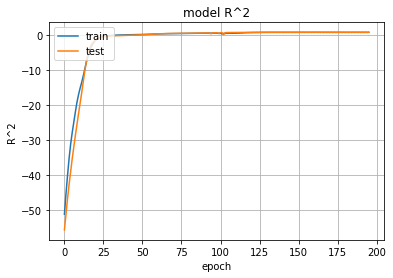

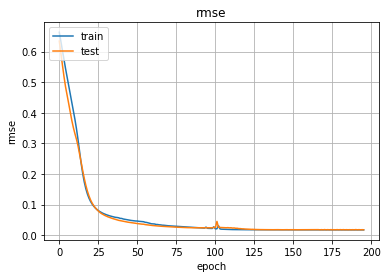

In [37]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(results.history['val_r_square'])
plt.plot(results.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# plot training curve for rmse
plt.plot(results.history['rmse'])
plt.plot(results.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Evaluating the performance

In [17]:
y_pred = model.predict(X_test)

In [23]:
y1 = post_process_output(y_pred, out_0_min, out_0_max, out_1_min, out_1_max)

In [24]:
y0 = post_process_output(y_test, out_0_min, out_0_max, out_1_min, out_1_max)

In [45]:
# Predicted values
y_pred[0,:,:,0][0][11:30]
# y1[0,:,:,0][0][11:30]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36583263, 0.43463036, 0.        , 0.        ,
       0.03743718, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [46]:
# Real values
y_test[0,:,:,0][0][11:30]
# y0[0,:,:,0][0][11:30]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10266447, 0.08679556, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [18]:
# Just testing on the validation data
model.evaluate(X_test, y_test)

65/65 [==============================] - 2s 36ms/step


[0.36307787895202637,
 0.015046848901189291,
 0.003943670068222743,
 0.017687374725937843,
 0.7028795480728149]

In [19]:
model.metrics_names

['loss', 'mean_absolute_error', 'mean_squared_error', 'rmse', 'r_square']